## Numeryczne Rozwiązywanie Rónań Różniczkowych Cząstkowych
### Uniwersytet Jagielloński 2021
Katedra Teorii Optymalizacji i Sterowania UJ

# Metoda różnic skończonych

## Laboratorium II
### Równanie paraboliczne

$$ u_{t} = u_{xx} \,\,\,\,\,\, x \in (0, 1), \,\,\,\, t > 0 $$

$$ u(t, 0) = u(t, 1) = 0 \,\,\,\,\,\, t>0 $$

$$ u(0, x) = \sin(\pi x) \,\,\,\,\,\, x \in [0, 1] $$

Rozwiązanie dokładne: $$ u(t, x) = e^{-\pi^2 t} \sin(\pi x) $$

In [1]:
import numpy as np
import scipy as sc
from mpl_toolkits.mplot3d import Axes3D

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from typing import Optional

#%matplotlib notebook

In [2]:
class SetupParabolic:
    def __init__(self,
                 dx: float,
                 dt: Optional[float] = None,
                 x_range = (0.0,1.0),
                 t_range = (0.0,2.0),
                 boundary_condition = (lambda t: 0, lambda t: 0),
                 initial_condition = lambda x: 0,
                 output_freq: int = 100,
                 alpha: float = 0
                 ):
        
        self.x_range = x_range
        self.t_range = t_range
        self.boundary_condition = boundary_condition
        self.initial_condition = initial_condition
        self.alpha = alpha  # just ignore it
        dt = dt or 0.5*(dx ** 2)

        # There are 2 hard problems in computer science:
        # cache invalidation, naming things, and off-by-1 errors.
        self.x_num = round((self.x_range[1] - self.x_range[0]) / dx) + 1
        self.t_num = round((self.t_range[1] - self.t_range[0]) / dt) + 1

        self.X, self.dx = np.linspace(*self.x_range, self.x_num, retstep=True)
        self.T, self.dt = np.linspace(*self.t_range, self.t_num, retstep=True)

        self.output_freq = output_freq
        

In [3]:
from scipy.sparse import dia_matrix

def Lh(setup):
    n = setup.x_num-2
    diag = np.ones(n)
    return (1/setup.dx**2)*dia_matrix(([diag, -2*diag, diag], [-1,0,1]), shape=(n,n))    

In [4]:
import scipy.sparse.linalg
from scipy.sparse import identity

def scheme_parabolic(setup):
    s = setup.dt/(setup.dx**2)
    if setup.alpha == 0 and s > 0.5: 
        raise Exception("alpha = 0, dt/dx^2 = " + str(s) + " - schemat jawny jest zbieżny tylko dla 0 < dt/dx^2 <= 1/2")

    T = np.linspace(*setup.t_range, setup.t_num // setup.output_freq)
    u_matrix = np.zeros((setup.x_num, setup.t_num // setup.output_freq))
    u_matrix[0,:] = [setup.boundary_condition[0](t) for t in T]
    u_matrix[-1,:] = [setup.boundary_condition[1](t) for t in T]
    u_matrix[:,0] = setup.initial_condition(setup.X)
    
    L = Lh(setup)
    if setup.alpha == 0:
        A = setup.dt*L + identity(setup.x_num-2)
    else:
        A = sc.sparse.linalg.inv(((1/setup.dt)*identity(setup.x_num-2) - setup.alpha*L).tocsc())*L + identity(setup.x_num-2)
    
    u = u_matrix[1:-1,0]
    for t in range(1, (setup.t_num // setup.output_freq) * setup.output_freq):
        u *= A
        if t % setup.output_freq == 0:
            u_matrix[1:-1, t // setup.output_freq] = u
    return u_matrix

In [5]:
def plot_surface(u, setup):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    # Prepare grid.
    T = np.linspace(*setup.t_range, setup.t_num // setup.output_freq)
    X = np.linspace(*setup.x_range, setup.x_num)
    T, X = np.meshgrid(T, X)

    # Plot the surface.
    surf = ax.plot_surface(T, X, u, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    # Customize the z axis.
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()
    #pass
    # TODO

In [6]:
%%time
# numerical solution
setup_parabolic = SetupParabolic(
    dx=0.01, dt=0.001,
    x_range = (0,1),
    t_range = (0,2),
    initial_condition = lambda x: np.sin(np.pi*x), # u(x,0) = sin(pi*x)
    boundary_condition = (lambda t: 0, lambda t: 0),          # u(0,t) = u(1,t) = 0
    output_freq = 10,
    alpha = 0.5
)
numerical_parabolic = scheme_parabolic(setup_parabolic)

CPU times: user 202 ms, sys: 28.7 ms, total: 230 ms
Wall time: 210 ms


In [7]:
# exact solution
exact = lambda t,x: np.exp(-(np.pi**2)*t) * np.sin(np.pi*x)
X = np.linspace(*setup_parabolic.x_range, setup_parabolic.x_num)
T = np.linspace(*setup_parabolic.t_range, setup_parabolic.t_num // setup_parabolic.output_freq)
X, T = np.meshgrid(X, T)

exact_parabolic = exact(T, X).T


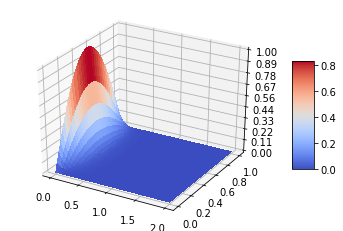

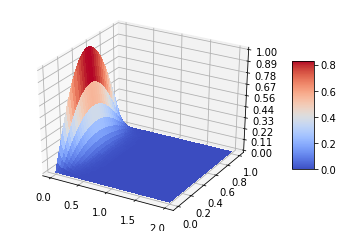

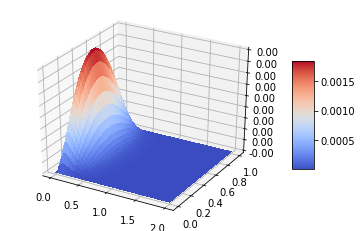

In [8]:
plot_surface(numerical_parabolic, setup_parabolic)
plot_surface(exact_parabolic, setup_parabolic)
plot_surface(numerical_parabolic - exact_parabolic, setup_parabolic)

#### Animacja

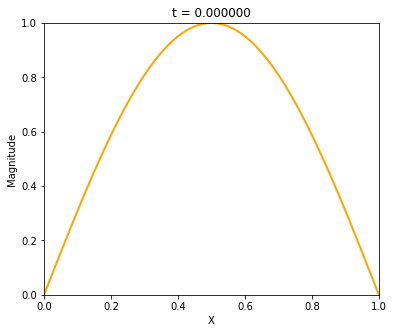

In [9]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# animation function. This is called sequentially
def drawframe(n):
    x = setup_parabolic.X
    y = numerical_parabolic[:, n]
    line1.set_data(x, y)
    txt_title.set_text('t = {0:4f}'.format(setup_parabolic.T[setup_parabolic.output_freq*n]))
    return (line1,)


# create a figure and axes
fig = plt.figure(figsize=(6,5))
ax1 = plt.subplot(1,1,1)   
# ax2 = plt.subplot(1,2,2)

# set up the subplots as needed
ax1.set_xlim(setup_parabolic.x_range)            
ax1.set_ylim((0, 1))
ax1.set_xlabel('X')
ax1.set_ylabel('Magnitude')

# create objects that will change in the animation. These are
# initially empty, and will be given new values for each frame
# in the animation.
txt_title = ax1.set_title('')
line1, = ax1.plot([], [], 'orange', lw=2)     # ax.plot returns a list of 2D line objects

from matplotlib import animation

# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=numerical_parabolic.shape[1], interval=20, blit=True)


In [10]:
from IPython.display import HTML
HTML(anim.to_html5_video())